# Observer

This Observer notebook monitors USB cameras for changes on the DMA playing field.

In [1]:
import json
import cv2
from collections import defaultdict
import numpy as np
import imutils
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode
from math import cos, degrees, radians
from time import sleep
from datetime import datetime
import requests

from dataclasses import dataclass
# %load_ext autotime

In [2]:
@dataclass
class CamCoordinate:
    x: int
    y: int
    

@dataclass
class RealCoordinate:
    x: float
    y: float

In [3]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel("FSRCNN_x4.pb")
sr.setModel("fsrcnn", 4);


def distanceFormula(pt0, pt1):
    return sum([(b - a)**2 for a, b in zip(pt0, pt1)]) ** 0.5


def capture_camera(cam_num):
    try:
        cam = cv2.VideoCapture(cam_num)
        retval, image = cam.read()
    finally:
        cam.release()
    retval, buff = cv2.imencode('.jpg', image)
    return buff


MAX_CAM_ID = 10


def identify_usb_cameras(device_numbers=list(range(MAX_CAM_ID))):
    functional = []
    for dn in device_numbers:
        try:
            img = capture_camera(dn)
            functional.append(dn)
        except Exception as e:
            continue
    return functional

In [4]:
@dataclass
class CalibrationBox:
    observedCorners: list[tuple]
    observedRect: list
    orientation: str
    realCoordinate: tuple
    
    millimetersPerPixel = 5
    
    def __post_init__(self):
        # if oC[1] changes  oC[0]'s y more than it's x, rotate point order
        # This tries to normalize the point order from the QR code so the image can be properly rotated
        oC0, oC1 = self.observedCorners[:2]
        if abs(oC1[0] - oC0[0]) > abs(oC1[1] - oC0[1]):
            self.observedCorners = [self.observedCorners[-1], *self.observedCorners[:-1]]
        
        acceptedOrientations = ['UP', 'LEFT', 'DOWN', 'RIGHT']
        assert self.orientation in acceptedOrientations, f"Unrecognized orientation: {orientation}"
        orientationIdx = acceptedOrientations.index(self.orientation)
        self.observedCorners = np.float32(self.observedCorners)
        self.cornerOrder = [[0, 1, 2, 3], [3, 0, 1, 2], [2, 3, 0, 1], [1, 2, 3, 0]][orientationIdx]
    
    @property
    def midpoint(self):
        x, y, w, h = self.observedRect
        return x + w/2, y + h/2

    @property
    def unwarpedCorners(self):
        mpx, mpy = self.realCoordinate
        wMod, hMod = 5, 5
        cornerModifiers = [(mpx - wMod, mpy - hMod), (mpx - wMod, mpy + hMod), (mpx + wMod, mpy + hMod), (mpx + wMod, mpy - hMod)]
        orderedModifiers = [cornerModifiers[idx] for idx in self.cornerOrder]
        return np.float32(orderedModifiers)

In [5]:
@dataclass
class Camera:
    camNum: int
    activeZone: list
    
    IMAGE_BUFFER_DEPTH = 2
    CAPTURE_FRAMES = 3
    xmax = 2560
    ymax = 1920

    @property
    def mostRecentFrame(self):
        return self.imageBuffer[0]
    
    def setActiveZone(self, newAZ):
        self.activeZone = np.float32(newAZ)

    def __post_init__(self):
        self.imageBuffer = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.imageDeltas = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.setActiveZone(self.activeZone)
        self.MCalibratedTo = None
        self.minimumWidth = 100
    
    def pointInActiveZone(self, p):
        return cv2.pointPolygonTest(self.activeZone, p, False) >= 0
    
    def tuneToCalibrationBox(self, calibrationBox: CalibrationBox):
        self.M = cv2.getPerspectiveTransform(calibrationBox.observedCorners, calibrationBox.unwarpedCorners)
        self.MCalibratedTo = calibrationBox.realCoordinate
    
    def calibrate(self, realBoxMidpoint=(0, 0)):
        rx, ry = 500 + (realBoxMidpoint[0] / CalibrationBox.millimetersPerPixel), 500 + (realBoxMidpoint[1] / CalibrationBox.millimetersPerPixel)
        try:
            decodes = decode(self.mostRecentFrame)
            decoded = decodes[0]
        except IndexError:
            raise Exception(f"Failed to locate QR Calibration Box on Camera {self.camNum}")
        self.tuneToCalibrationBox(CalibrationBox(decoded.polygon, decoded.rect, decoded.orientation, (rx, ry)))
        return len(decodes)

    def convertCameraToRealSpace(self, p):
        assert not (self.M is None), "Must calibrate camera before converting coordinates"
        M = self.M
        px = (M[0][0]*p[0] + M[0][1]*p[1] + M[0][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        py = (M[1][0]*p[0] + M[1][1]*p[1] + M[1][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        return (px, py)
    
    @staticmethod
    def distanceFormula(pt0, pt1):
        return sum([(b - a)**2 for a, b in zip(pt0, pt1)]) ** 0.5
    
    def cameraPointsToRealDistance(self, pt0, pt1):
        """ Calculates distance between cam's RealSpace coordinates to distance in mm """
        ptr0 = cam0.convertCameraToRealSpace(pt0)
        ptr1 = cam0.convertCameraToRealSpace(pt1)
        return self.distanceFormula(ptr0, ptr1) * CalibrationBox.millimetersPerPixel
        
    def showUnwarpedImage(self):
        warp = cv2.warpPerspective(self.cropToActiveZone(self.imageBuffer[0]), self.M, (1000, 1000))
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(warp)
        plt.show()
        return warp
    
    def collectImage(self) -> np.ndarray:
        cap = cv2.VideoCapture(self.camNum)
        sleep(delay)
        image = None
        try:
            for frame in range(self.CAPTURE_FRAMES):
                ret, cv2_im = cap.read()
                sleep(delay)
            image = sr.upsample(cv2_im)
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        finally:
            cap.release()
        return image
    
    @staticmethod
    def boxToBasePoint(box):
        x, y, w, h = box
        return (int(x + w / 2), int(y + h * 0.75))
    
    def changeBetween(self, im0, im1):
        if im0 is None or im1 is None:
            return []
        img_height = im0.shape[0]
        diff = cv2.absdiff(cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))
        thresh = cv2.threshold(diff,64,255,cv2.THRESH_BINARY)[1]
        kernel = np.ones((5,5), np.uint8) 
        dilate = cv2.dilate(thresh, kernel, iterations=2)
        contours = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)
        boxes = []
        for contour in contours:
            bRect = cv2.boundingRect(contour)
            x, y, w, h = bRect
            area = w * h
            presumedBasePoint = self.boxToBasePoint((x, y, w, h))
            if 10000000 > area > 10000 and self.pointInActiveZone(presumedBasePoint):
                boxes.append(cv2.boundingRect(contour))
        return boxes
    
    def captureTransition(self, box):
        x, y, w, h = box
        before = self.imageBuffer[1][y:y+h, x:x+w]
        after = self.imageBuffer[0][y:y+h, x:x+w]
        return before, after
    
    def capture(self):
        newImage = self.collectImage()
        delta = self.changeBetween(self.imageBuffer[1], newImage)
        self.imageDeltas.insert(0, delta)
        self.imageDeltas.pop()
        transitions = [self.captureTransition(d) for d  in delta]
        return newImage, delta, transitions
    
    def cropToActiveZone(self, image):
        pts = np.int32(self.activeZone)
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
        dst = cv2.bitwise_and(image, image, mask=mask)
        return dst
        
    def drawActiveZone(self, image):
        pts = np.int32(self.activeZone)
        azOverlaidImage = image.copy()
        return cv2.polylines(azOverlaidImage, [pts], isClosed=True, color=(0,255,0), thickness=5)

    @classmethod
    def drawBoxesOnImage(cls, image, boxes, color=(0,0,255)):
        imageWithBoxes = image.copy()
        for x, y, w, h in boxes:
            cv2.rectangle(imageWithBoxes, (x, y), (x+w, y+h), color, 2)
            presumedBasePoint = cls.boxToBasePoint((x, y, w, h))
            cv2.circle(imageWithBoxes, presumedBasePoint, radius=4, thickness=4, color=(0,255,255))
            cv2.putText(imageWithBoxes, f'{x}-{x+w}, {y}-{y+w}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
        return imageWithBoxes

    def showTransition(self, i0, i1):
        changes = self.changeBetween(i0, i1)
        return np.hstack((
            self.drawBoxesOnImage(i0, changes),
            np.zeros((i0.shape[0], 10, 3), np.uint8),
            self.drawBoxesOnImage(i1, changes)))
    
    @staticmethod
    def swapBox(srcIm, dstIm, box):
        swapped = dstIm.copy()
        x, y, w, h = box
        orig = srcIm[y:y+h, x:x+w]
        swapped[y:y+h, x:x+w] = orig
        return swapped
        
    def showActiveZone(self):
        print(self.activeZone)
        self.capture()
        plt.imshow(self.drawActiveZone(self.mostRecentFrame))
        plt.show()

In [6]:
@dataclass
class RemoteCamera(Camera):
    address: str
    rotate: bool = False

    def collectImage(self) -> np.ndarray:
        image = None
        try:
            for i in range(5):
                resp = requests.get(self.address, stream=True).raw
                image = np.asarray(bytearray(resp.read()), dtype="uint8")
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                if self.rotate:
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                if image is not None:
                    break
            assert image is not None, f"Failed to collect image for Camera {self.camNum}"
            
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        return image

In [7]:
@dataclass
class CaptureObject:
    name: str
    realCoords: tuple
    camBoxes: {int: list[int]}
    
    def camCoordinateMatch(self, coords: {int: CamCoordinate}, wiggle=80) -> bool:
        for camNum, coord in coords.items():
            x, y = coord.x, coord.y
            for camBox in self.camBoxes[camNum]:
                capX, capY, _, _ = camBox
                if x - wiggle < capX < x + wiggle and y - wiggle < capY < y + wiggle:
                    return True
        return False
    
    def update(self, camBoxes):
        self.camBoxes = camBoxes

In [8]:
@dataclass
class CaptureConfiguration:
    name: str
    captureObjects: {str: CaptureObject} = None
    
    def __post_init__(self):
        self.roundCounter = 0
        self.captureObjects = {} if self.captureObjects is None else self.captureObjects
        self.lastCapture = None
    
    def capture(self):
        self.lastCapture = {cam.camNum: cam.capture() for cam in cameras.values()}
        return self.lastCapture
        
    def defineObject(self, name: str, captures: dict):
        camBoxes = {int(camNum): capture[1] for camNum, capture in captures.items()}
        realCoords = self.camBoxesToRealCoordinates(camBoxes)
        self.captureObjects[name] = CaptureObject(name, realCoords, camBoxes)

    def camBoxesToRealCoordinates(self, camBoxes):
        xs, ys = zip(*[
            cameras[camNum].convertCameraToRealSpace(Camera.boxToBasePoint(boxes[0]))
            for camNum, boxes in camBoxes.items()
            if len(boxes) > 0])
        return sorted(xs)[int(len(xs)/2)], sorted(ys)[int(len(ys)/2)]

    def distanceBetween(self, obj0, obj1):
        pt0 = self.captureObjects[obj0].realCoords
        pt1 = self.captureObjects[obj1].realCoords
        return distanceFormula(pt0, pt1) * CalibrationBox.millimetersPerPixel

    def updateObject(self, name: str, camBoxes: {int: list[int]}):
        self.captureObjects[name].update(camBoxes)
        self.captureObjects[name].realCoords = self.camBoxesToRealCoordinates(camBoxes)

    def identifySelectedObject(self, captures):
        camCaptures = {cN: cap[1] for cN, cap in captures.items()}
        for capObj in self.captureObjects.values():
            originMatches = {cN: [] for cN in cameras}
            transition = {cN: [None, None] for cN in cameras}
            for camNum, (newImage, changeBoxes, transitions) in captures.items():
                for bid, box in enumerate(changeBoxes):
                    if capObj.camCoordinateMatch({camNum: CamCoordinate(*box[:2])}):
                        originMatches[camNum].append(box)
                        transition[camNum][0] = transitions[bid]
            if sum([len(capObj.camBoxes[cN]) == len(originMatches[cN]) for cN in cameras]) == len(cameras):
                return capObj, originMatches, transition
        raise Exception("Unable to Identify Object to Update")
    
    def scanCamsForCalibrationBoxes(self):
        return {cam.camNum: (qrs := decode(cam.mostRecentFrame), len(qrs)) for cam in cameras.values()}
    
    def objectsByBoxOrigin(self, coord: CamCoordinate):
        objs = []
        for objName, obj in self.captureObjects.items():
            if obj.camCoordinateMatch(coord):
                objs.append(obj)
        return objs
    
    def drawObjectsOnCam(self, cam, image=None):
        img = (cam.imageBuffer[0] if image is None else image).copy()
        for obj in self.captureObjects.values():
            if cam.camNum in obj.camBoxes:
                img = cam.drawBoxesOnImage(img, obj.camBoxes[cam.camNum])
        return img
    
    def drawDeltasOnCam(self, cam, image=None):
        img = (cam.imageBuffer[0] if image is None else image).copy()
        cam.drawBoxesOnImage(img, self.lastCapture[cam.camNum][1], color=(255, 0, 0))
        return img
        
    def showCameras(self):
        f, ax = plt.subplots(1, len(cameras), figsize=(20,20))
        for a, cam in zip(ax, cameras.values()):
            a.imshow(self.drawObjectsOnCam(cam, cam.drawActiveZone(cam.imageBuffer[0])))
            a.set_title(f"Cam{cam.camNum}")
        plt.show()
    
    def showCamsUnwarped(self, cams=None):
        cams = cams if cams is not None else list(cameras.values())
        f, ax = plt.subplots(1, len(cams), figsize=(10, 10))
        altogether = None
        for axes, cam in zip(ax, cams):
            warp = cv2.warpPerspective(cam.cropToActiveZone(cam.mostRecentFrame), cam.M, (1000, 1000))
            altogether = cv2.addWeighted(altogether, 0.5, warp, 0.5, 0) if altogether is not None else warp
            axes.imshow(warp)
            axes.set_title(f"Cam{cam.camNum}")
        plt.show()
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
        plt.imshow(altogether)
        plt.show()
        
    def showCameraDelta(self, initial=1, final=0):
        camImages = []
        for cam in cameras.values():
            changes = cam.changeBetween(cam.imageBuffer[initial], cam.imageBuffer[final])
            camImages.append(cam.drawActiveZone(cam.drawBoxesOnImage(cam.imageBuffer[final], changes)))
        f, ax = plt.subplots(1, len(cameras), figsize=(20, 20))
        for a, cam, ci in zip(ax, cameras.values(), camImages):
            a.imshow(ci)
            a.set_title(f"Cam{cam.camNum}")
        plt.show()
    
    def calibrate(self, calibrationBoxRealCoordinates={0: [500 + (110 / 5), 500 - (160 / 5)], 2: [500 + (110 / 5), 500 - (160 / 5)], 4: [500, 500]}):
        self.capture()
        decodes = cc.scanCamsForCalibrationBoxes()
        for camNum, (decodes, numDecodes) in decodes.items():
            if camNum not in calibrationBoxRealCoordinates:
                continue
                
            cam = cameras[camNum]
            cam.calibrationBox(CalibrationBox(dec.polygon, decodes[0].rect, dec.orientation, calibrationBoxRealCoordinates[camNum]))
    
    def debugCapture(self):
        captures = self.capture()
        print({cam: [d for d in camCap[1]] for cam, camCap in captures.items()})
        self.showCameraDelta()
        return captures
    
    def saveState(self):
        state = {
            camNum: {
                "addr": cam.address,
                "rot": cam.rotate,
                "az": json.dumps(cam.activeZone.tolist()),
                "mw": cam.minimumWidth,
                "m": json.dumps(cam.M.tolist()) if cam.M is not None else None,
                "mct": cam.MCalibratedTo if cam.M is not None else None}
            for camNum, cam in cameras.items()}
        state["objs"] = {name: capObj.camBoxes
                         for name, capObj in self.captureObjects.items()}
        state["pov"] = {
            "addr": pov.address,
            "rot": pov.rotate
        }
        with open("observerState.json", "w") as f:
            f.write(json.dumps(state, indent=2))
            
    def recoverState(self):
        with open("observerState.json", "r") as f:
            state = json.loads(f.read())
        for camNum, camDef in state.items():
            if str(camNum) == "objs":
                cc.captureObjects = {name: CaptureObject(
                                        name=name,
                                        camBoxes=(camBoxes:={int(camNum): boxes for camNum, boxes in camBox.items()}),
                                        realCoords=self.camBoxesToRealCoordinates(camBoxes))
                                     for name, camBox in camDef.items()}
            elif str(camNum) == "pov":
                global pov
                addr = camDef['addr']
                rot = camDef['rot']
                pov = RemoteCamera(address=addr, rotate=rot, activeZone=[], camNum=-99)
            else:
                addr = camDef['addr']
                az = np.float32(json.loads(camDef['az']))
                cameras[int(camNum)] = RemoteCamera(address=addr, activeZone=az, camNum=int(camNum))
                cameras[int(camNum)].M = None if camDef['m'] is None else np.float32(json.loads(camDef['m']))
                cameras[int(camNum)].MCalibratedTo = camDef.get('mct', None)

In [9]:
cameras = defaultdict(lambda x: None)
pov = None
cc = CaptureConfiguration(__name__, {})

In [10]:
cc.recoverState()

{0: [], 2: [], 4: []}


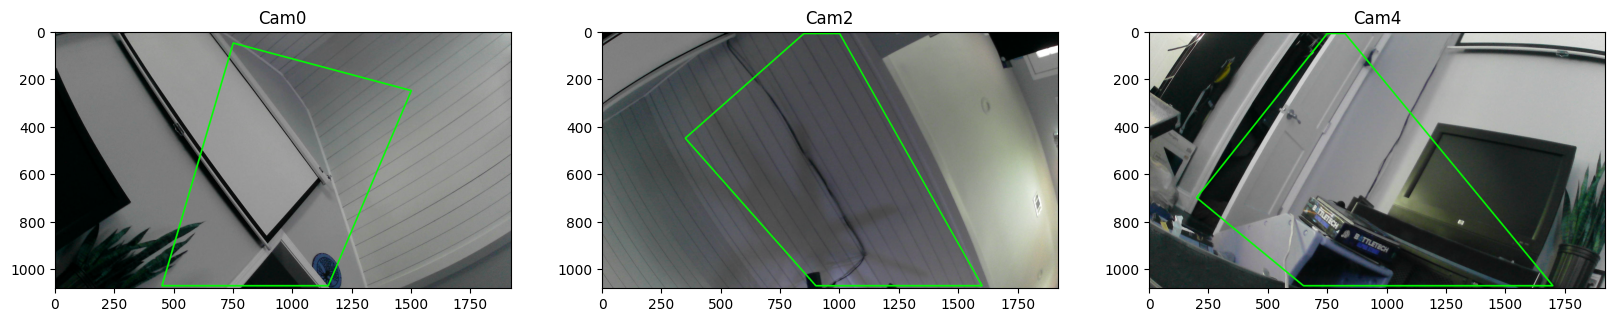

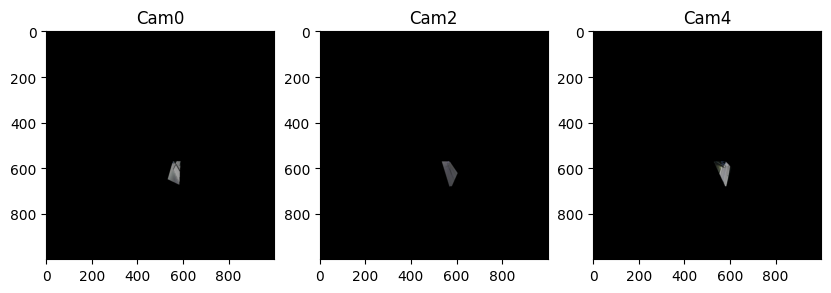

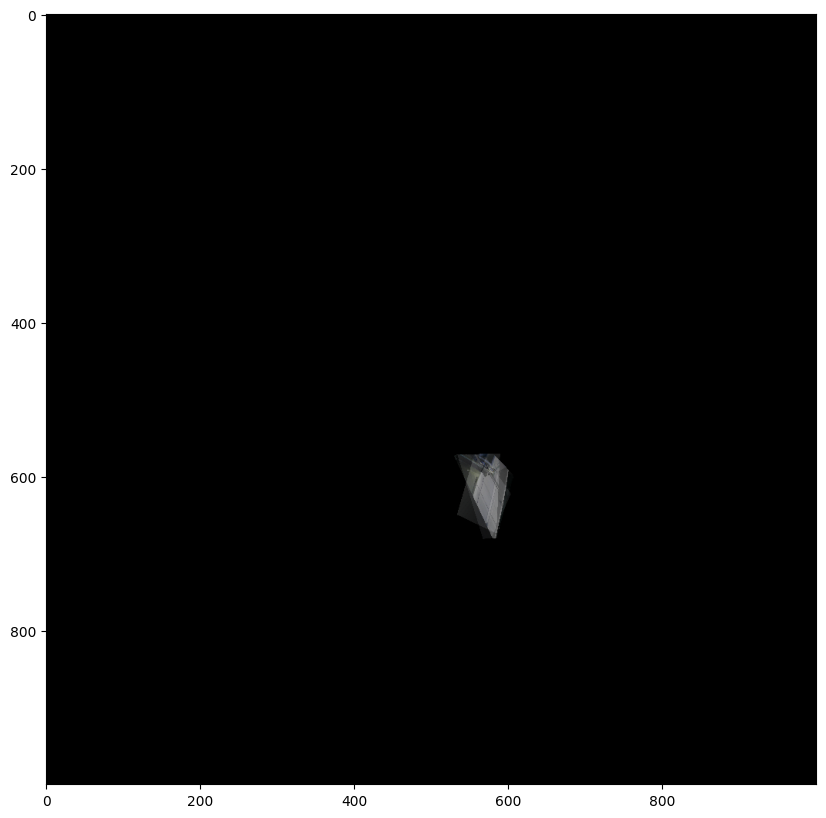

In [11]:
if __name__ == "__main__":
    cc.debugCapture()
    cc.showCamsUnwarped()